In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from scipy import signal
import scipy
import pandas as pd
import sys

sys.path.append("../pytorch-unet-segmentation-master/src/")
sys.path.append("../pytorch-unet-segmentation-master/scripts/")
from save_history import *
from modules import *
from dataset import *
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import Postprocesamiento
import LoadDataset
import LoadCZI
import CreatePNG
import Preprocesamiento
import Tracking
import TrackingConCelulasBorde

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load CZI data

In [2]:
path0="../pytorch-unet-segmentation-master/test2/test2.czi"
image_arrays = LoadCZI.load(path0)

Create PNG images

In [3]:
path1="../pytorch-unet-segmentation-master/Claudio_png/test"
CreatePNG.png(path1,image_arrays)

Preprocesamiento and save PNG images

In [4]:
pathRead='../pytorch-unet-segmentation-master/Claudio_png/test/'
pathLoad="../pytorch-unet-segmentation-master/preprocesada/test/"
OrigiANDPrepro=Preprocesamiento.preprocesing(pathRead,pathLoad)
original=OrigiANDPrepro[0] #original 
preprocesada=OrigiANDPrepro[1] #preprocesada

Mostrar original y preprocesada

<IPython.core.display.Javascript object>


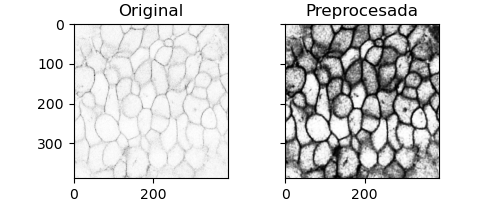

Text(0.5, 1.0, 'Preprocesada')

In [10]:
img_num=5
fig, ax = plt.subplots(1, 2, figsize=(5, 2), sharex=True, sharey=True)
ax[0].imshow(original[img_num], cmap=plt.cm.Greys_r)
ax[0].set_title('Original')
ax[1].imshow(preprocesada[img_num], cmap=plt.cm.Greys_r)
ax[1].set_title('Preprocesada')

Define dataset, aplica modelo y watershed

In [6]:
path="../pytorch-unet-segmentation-master/preprocesada"
claudio_loader= LoadDataset.loadData(path)
modelo= '../pytorch-unet-segmentation-master/modelos/model_epoch_440.pwf'
paramThresh = 0.1 #parametro visto en reu
water = Postprocesamiento.postprocesing(claudio_loader, modelo, paramThresh)

Definir las salidas del modelo

In [7]:
image=water[0] #imagen con padd
output=water[1] #mascara binaria
img_list=water[2] #lista mascaras binarias
water_list=water[3] #lista imagens watershed
watershed=water[4] #funcion watershed

Muestra imagen con pad, imagen binarizada, y preprocesada

<IPython.core.display.Javascript object>


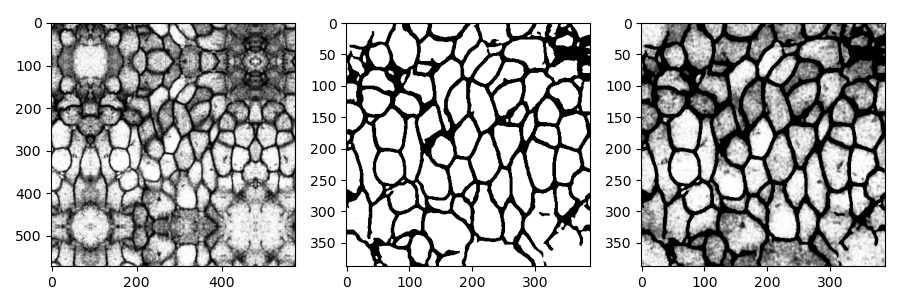

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
pad = (572-388)//2
ax[0].imshow(image.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output.numpy()[0], cmap=plt.cm.Greys_r)
borders_on_top = image.numpy()[0, 0, pad:-pad, pad:-pad].copy()
idx = np.where(output.numpy()[0].astype(int) == 0)
borders_on_top[idx[0], idx[1]] = 0
ax[2].imshow(borders_on_top, cmap=plt.cm.Greys_r)

Muestra dos ejemplos de imagen binarizada y watershed

<IPython.core.display.Javascript object>


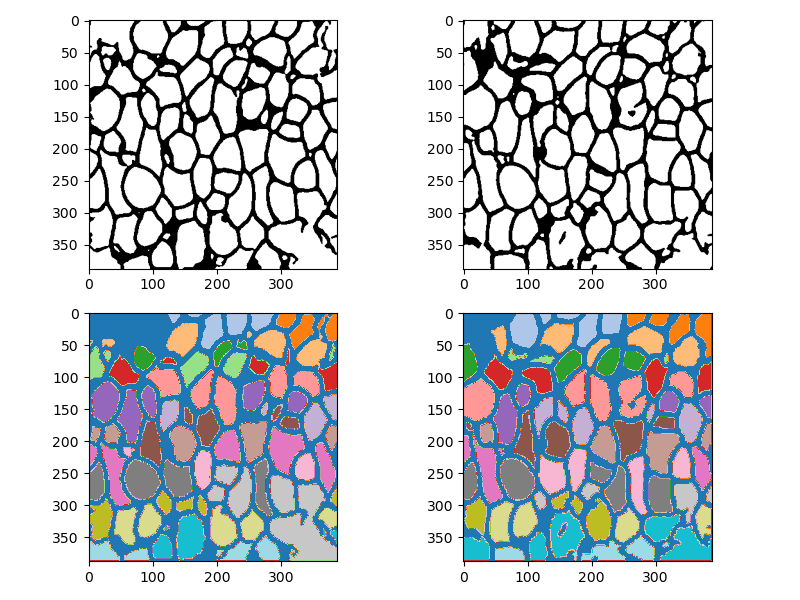

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
ax[0, 0].imshow(img_list[0], cmap=plt.cm.Greys_r)
ax[1, 0].imshow(water_list[0], cmap=plt.cm.tab20)
ax[0, 1].imshow(img_list[13], cmap=plt.cm.Greys_r)
ax[1, 1].imshow(water_list[13], cmap=plt.cm.tab20)

Escoger célula a trackear y aplicar vecinos mas cercanos

In [27]:
cell_idx = 68 #celula a trackear
paramDist= 10
tracking = Tracking.vecinosMasCercanos(watershed,water_list,cell_idx,paramDist)

In [28]:
cell_idx_history= tracking[0] #historia de posiciones de la celula
new_size_cell = tracking[1] #tamaño de la celula
closestList=tracking[2]

Muestra grafico de area y animación de la célula

<IPython.core.display.Javascript object>


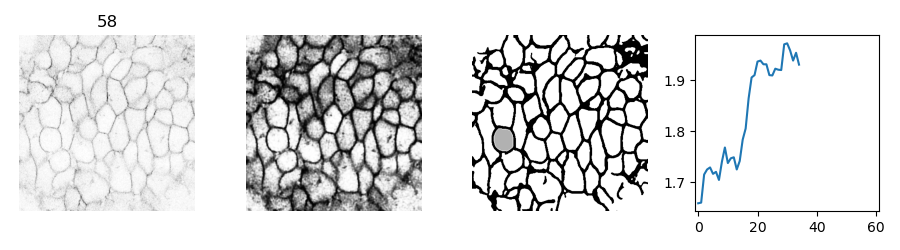

In [47]:
from matplotlib.animation import FuncAnimation, writers

fig, ax = plt.subplots(1, 4, figsize=(9, 2.5), tight_layout=True)
ax[-1].plot(new_size_cell)
ax[-1].set_xlim([-1, 61])
dot = ax[-1].scatter(0, new_size_cell[0], marker='o', color='r')

def update_plot(k):
    for ax_ in ax[:3]:
        ax_.cla()
        ax_.axis('off')
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 150
    ax[0].set_title(k)
    ax[0].imshow(original[k], cmap=plt.cm.Greys_r)
    ax[1].imshow(preprocesada[k], cmap=plt.cm.Greys_r)
    #ax[1].imshow(claudio_loader.dataset[k][0][0].numpy(), cmap=plt.cm.Greys_r)
    ax[2].imshow(img, cmap=plt.cm.Greys_r)
    dot.set_offsets([k, new_size_cell[k]])
    
ani = FuncAnimation(fig, update_plot, frames=len(new_size_cell), repeat=False, interval=1000)
#update_plot(32)

In [49]:
Writer = writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=-1)
ani.save("anim.mp4", writer=writer)

Número de células por dataFrame

<IPython.core.display.Javascript object>


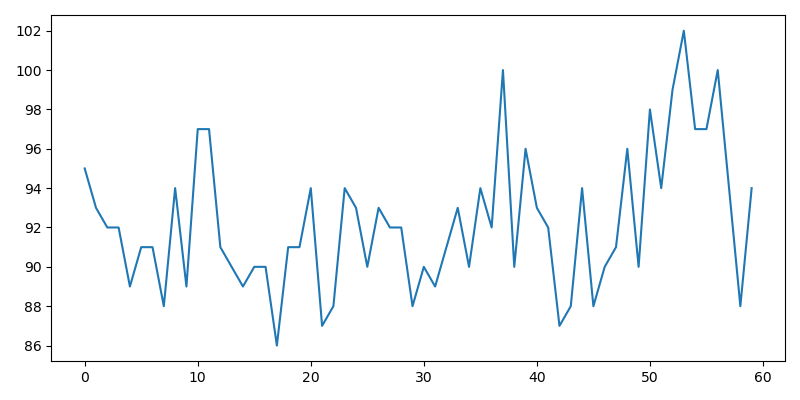

In [19]:
numeroDeCelulas=[]
for x in range (0,60):
    numero=np.amax(water_list[x], axis=None, out=None)
    numeroDeCelulas.append(numero)
fig, ax = plt.subplots(1,1, figsize=(8, 4), tight_layout=True)
ax.plot(numeroDeCelulas)

Saca el area de todas las celulas, ya sea si estan en el borde o no, y las exporta a excel

In [20]:
import openpyxl
numero=np.amax(water_list[0], axis=None, out=None)
ListOfSize=[]
for x in range (0, numero+1):
    cell_idx = x #celula a trackear
    tracking = TrackingConCelulasBorde.vecinosMasCercanos(watershed,water_list,cell_idx, paramDist) 
    #cell_idx_history= tracking[0] #historia de posiciones de la celula
    new_size_cell = tracking [1] #tamaño de la celula
    ListOfSize.append(new_size_cell)

df=pd.DataFrame(ListOfSize)
ruta="../pytorch-unet-segmentation-master/tamañoCelulas.xlsx"
df.to_excel(ruta, sheet_name='areas')
#df

ModuleNotFoundError: No module named 'openpyxl'

Tracking de 2 células paramThresh= 0,1

<IPython.core.display.Javascript object>


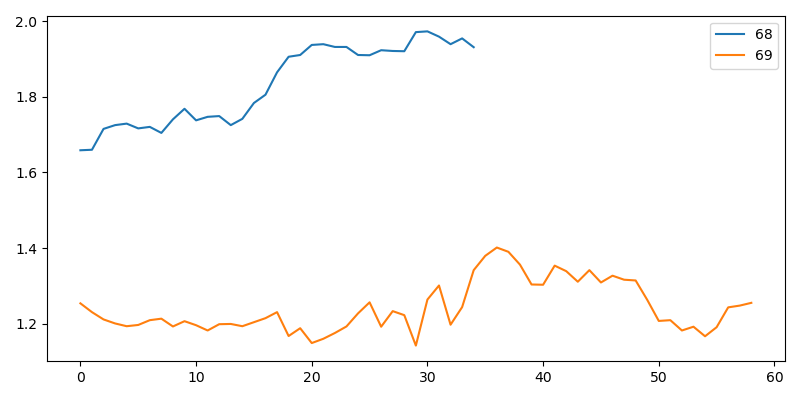

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8, 4), tight_layout=True)
for x in [68, 69]:
    cell_idx = x #celula a trackear
    tracking = Tracking.vecinosMasCercanos(watershed,water_list,cell_idx, paramDist) 
    #cell_idx_history= tracking[0] #historia de posiciones de la celula
    new_size_cell = tracking [1] #tamaño de la celula
    ax.plot(new_size_cell, label=x)
    ax.legend()

Histograma imagen binarizada

In [ ]:
plt.figure()
plt.hist(image.numpy()[0, 0].ravel())

<IPython.core.display.Javascript object>


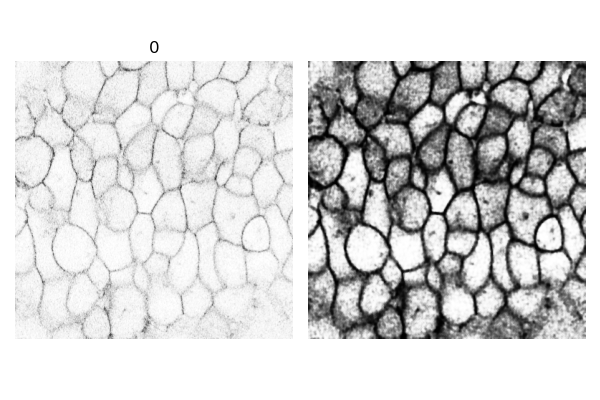

interactive(children=(IntSlider(value=0, description='k', max=59), Output()), _dom_classes=('widget-interact',…

<function __main__.update(k)>

In [22]:
fig, ax = plt.subplots(1,2, figsize=(6, 4), tight_layout=True)
ax[0].plot(scipy.signal.medfilt(new_size_cell, 3))
from matplotlib.animation import FuncAnimation
def update(k):
    ax[1].cla()
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 150
    for idx in np.unique(water_list[k])[2:]:
        coords = np.mean(np.where(water_list[k]==idx), axis=1)
        ax[1].scatter(coords[1], coords[0], marker='o', s=5, color='r')
    ax[1].imshow(img, cmap=plt.cm.Greys_r)
    ax[1].set_title(k)
#ani = FuncAnimation(fig, update, frames=60, repeat=False, interval=200)
from ipywidgets import IntSlider, interact
interact(update, k=IntSlider(min=0, max=59))